<a href="https://colab.research.google.com/github/MakotoNakai/Mitou-2019-Quantum-GAN/blob/master/qWGAN_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


QWGAN
---



In [0]:
#!/usr/bin/env python

"""
    qcircuit.py: including base components and definition of quantum circuit simulation.

"""
import traceback

import numpy as np
import scipy.linalg as linalg
import os
import random

import sys
from scipy.sparse import dok_matrix

Ide = np.matrix(np.eye(2))
# Pauli matrices
Pauli_X = np.matrix([[0, 1], [1, 0]])  #: Pauli-X matrix
Pauli_Y = np.matrix([[0, -1j], [1j, 0]])  #: Pauli-Y matrix
Pauli_Z = np.matrix([[1, 0], [0, -1]])  #: Pauli-Z matrix
Hadamard = np.matrix([[1, 1], [1, -1]]) / np.sqrt(2)  #: Hadamard gate

global param_table
param_table = dict()

def Identity(nqubits):
  mat = 1
  for i in range(nqubits):
    mat = np.kron(Ide, mat)
  return mat

def X(nqubits, qubit, param, is_grad):
  mat = 1
  for i in range(nqubits):
    if i == qubit:
      mat = np.kron(Pauli_X, mat)
    else:
      mat = np.kron(Ide, mat)
  return mat

def Y(nqubits, qubit, param, is_grad):
  mat = 1
  for i in range(nqubits):
    if i == qubit:
      mat = np.kron(Pauli_Y, mat)
    else:
      mat = np.kron(Ide, mat)
  return mat

def Z(nqubits, qubit, param, is_grad):
  mat = 1
  for i in range(nqubits):
    if i == qubit:
      mat = np.kron(Pauli_Z, mat)
    else:
      mat = np.kron(Ide, mat)
  return mat

def H(nqubits, qubit, param, is_grad):
  mat = 1
  for i in range(nqubits):
    if i == qubit:
      mat = np.kron(Hadamard, mat)
    else:
      mat = np.kron(Ide, mat)
  return mat

def qiskit_order(nqubits):
  states = []
  binary = ['0', '1']

  for i in binary:
    for j in binary:
      for k in binary:
        states.append(k+j+i)
  return states

def find_string_in_qiskit_order(nqubits, binary):
  order = qiskit_order(nqubits)
  index = 0
  if binary not in order:
    print("Put another string")
  for num in range(len(order)):
    if order[num] == binary:
      index += num
  return index

def CNOT(nqubits, qubit1, qubit2, param, is_grad):
  if qubit1 > nqubits or qubit2 > nqubits or qubit1 == qubit2:
    print("You entered the wrong pair of qubits")

# 2進数の長さ
  length = len(bin(nqubits)[2:])

  # 考えられるすべての状態
  states = [format(num,str(length).zfill(2)+'b').zfill(nqubits) for num in range(2**nqubits)]
  # 制御量子ビットが1のすべての状態(2進数方式)
  controlled_states = [state for state in states if state[qubit1]=='1']
  # 上の文字列を数値にした時の状態(整数)
  # 制御されるすべての状態
  target_states = []
  for state in controlled_states:
    # target qubitが0の時、1に反転させる
    if state[qubit2] == '0':
      state_list = list(state)
      state_list[qubit2] = '1'
      target_str = "".join(state_list)
      # target_int = int(target_str,2)
    # target qubitが1の時、0に反転させる
    else:
      state_list = list(state)
      state_list[qubit2] = '0'
      target_str = "".join(state_list)
      # target_int = int(target_str,2)
    target_states.append(target_str)
    # target_states.append(target_int)
  # #(2**nqubits)^2の正方行列
  mat = Identity(nqubits)
  mat = np.array(mat)
  for control, target in zip(controlled_states, target_states):
    cont_int = find_string_in_qiskit_order(nqubits,control)
    tar_int = find_string_in_qiskit_order(nqubits,target)
    mat[cont_int][cont_int] = 0
    mat[cont_int][tar_int] = 1
    mat[tar_int][cont_int] = 1
    mat[tar_int][tar_int] = 0

  return np.matrix(mat)

def CNOT_Rotation(size, qubit1, qubit2, param, is_grad):
    matrix = CNOT(size, qubit1, qubit2, param, is_grad)
    return matrix

def single_RX(theta):
  sin = np.sin(theta/2)
  cos = np.cos(theta/2)
  mat = np.array([[cos, -1J*sin],[-1J*sin, cos]])
  mat = np.matrix(mat)
  return mat

def single_RY(theta):
  sin = np.sin(theta/2)
  cos = np.cos(theta/2)
  mat = np.array([[cos, -sin],[sin, cos]])
  mat = np.matrix(mat)
  return mat

def single_RZ(theta):
  # mat = np.array([[1,0],[0,np.exp(1J*theta)]])
  mat = np.array([[np.exp(-1J*theta/2),0],[0,np.exp(1J*theta/2)]])
  mat = np.matrix(mat)
  return mat

def RX(size, qubit, param, is_grad):
    matrix = 1
    for i in range(size):
        if qubit == i:
            if is_grad == False:
                try:
                    matrix = np.kron(single_RX(param),matrix)
                except Exception:
                    print('param:\n:', param)
            else:
                matrix = np.kron(-1J / 2 * Pauli_X * single_RX(param),matrix)
        else:
            matrix = np.kron(Ide,matrix)

    return matrix

def RY(size, qubit, param, is_grad):
    matrix = 1
    for i in range(size):
        if qubit == i:
            if is_grad == False:
                try:
                    matrix = np.kron(single_RY(param), matrix)
                except Exception:
                    print('param:\n:', param)
            else:
                matrix = np.kron(-1J / 2 * Pauli_Y * single_RY(param), matrix)
        else:
            matrix = np.kron(Ide, matrix)

    return matrix

def RZ(size, qubit, param, is_grad):
    matrix = 1
    for i in range(size):
        if qubit == i:
            if is_grad == False:
                try:
                    matrix = np.kron(single_RZ(param),matrix)
                except Exception:
                    print('param:\n:', param)
            else:
                matrix = np.kron(1J / 2 * Pauli_Z * single_RZ(param),matrix)
        else:
            matrix = np.kron(Ide, matrix)

    return matrix
    

def Global_phase(size, param, is_grad):
    matrix = np.eye(2**size)
    eA = np.exp(-1J * param**2) * matrix
    if is_grad == False:
        return eA
    else:
        return -1J *2 * param * np.matmul(matrix,eA)



class Quantum_Gate:
    def __init__(self, name, qubit1=None, qubit2=None, **kwarg):
        self.name = name
        self.qubit1 = qubit1
        self.qubit2 = qubit2
        self.r = self.get_r()
        self.s = self.get_s()

        if "angle" in kwarg:
            self.angle = kwarg["angle"]
        else:
            self.angle = None

    def get_r(self):
        if self.name == 'RX' or self.name == 'RY' or self.name == 'RZ' or self.name == 'ZZ':
            return 1/2
        elif self.name == 'XX' or self.name == 'YY':
            return 1
        else:
            return None

    def get_s(self):
        if self.r != None:
            return np.pi / (4 * self.r)
        else:
            return None

    def matrix_representation(self, size, is_grad):

        if self.angle != None:
            try:
                param = float(self.angle)
            except:
                param = param_table[self.angle]

        elif (self.name == "RZ"):
            return RZ(size, self.qubit1, param, is_grad)

        elif (self.name == "RX"):
            return RX(size, self.qubit1, param, is_grad)

        elif (self.name == "RY"):
            return RY(size, self.qubit1, param, is_grad)

        elif (self.name == "Z"):
            return Z(size, self.qubit1, param, is_grad)

        elif (self.name == "X"):
            return X(size, self.qubit1, param, is_grad)

        elif (self.name == "Y"):
            return Y(size, self.qubit1, param, is_grad)
            
        elif (self.name == "H"):
            return Hadamard(size, self.qubit1)

        elif (self.name == "CNOT"):
            # return mCNOT(size, self.qubit1, self.qubit2)
            return CNOT_Rotation(size, self.qubit1, self.qubit2, param, is_grad)
        elif (self.name == "G"):
            return Global_phase(size, param, is_grad)
        else:
            raise ValueError("Gate is not defined")

    def matrix_representation_shift_phase(self, size, is_grad, signal):

        if self.angle != None:
            try:
                if self.name == 'G':
                    param = float(self.angle)
                else:
                    param = float(self.angle)
                    if is_grad == True:
                        if signal == '+':
                            param = param + self.s
                        else:
                            param = param - self.s
                        is_grad = False
            except:
                param = param_table[self.angle]

        elif (self.name == "RZ"):
            return RZ(size, self.qubit1, param, is_grad)

        elif (self.name == "RX"):
            return RX(size, self.qubit1, param, is_grad)

        elif (self.name == "RY"):
            return RY(size, self.qubit1, param, is_grad)

        elif (self.name == "Z"):
            return Z(size, self.qubit1, param, is_grad)

        elif (self.name == "X"):
            return X(size, self.qubit1, param, is_grad)

        elif (self.name == "Y"):
            return Y(size, self.qubit1, param, is_grad)
        
        elif (self.name == "H"):
            return Hadamard(size, self.qubit1, param, is_grad)

        elif (self.name == "G"):
            return Global_phase(size, param, is_grad)

        elif (self.name == "CNOT"):
            # return mCNOT(size, self.qubit1, self.qubit2)
            return CNOT_Rotation(size, self.qubit1, self.qubit2, param, is_grad)

        else:
            raise ValueError("Gate is not defined")


class Quantum_Circuit:

    def __init__(self, size, name):
        self.size = size
        self.depth = 0
        self.gates = []
        self.name = name

    def check_ciruit(self):
        for j,gate in zip(range(len(self.gates)),self.gates):
            if gate.qubit1!=None and gate.qubit2!=None:
                if gate.qubit1>self.size-1:
                    print('Error: #{} gate:{} 1qubit is out of range'.format(j, gate.name))
                    os._exit(0)
                elif gate.qubit2>self.size-1:
                    print('Error: #{} gate:{} 2qubit is out of range'.format(j, gate.name))
                    os._exit(0)

    def get_mat_rep(self):
        matrix = Identity(self.size)
        for gate in self.gates:
            g = gate.matrix_representation(self.size, False)
            matrix = np.matmul(g, matrix)
        return np.asmatrix(matrix)

    def get_grad_mat_rep(self, index, signal='none', type='matrix_multiplication'):
        '''
            matrix multipliction: explicit way to calculate the gradient using matrix multiplication
            shift_phase: generate two quantum circuit to calculate the gradient
            Evaluating analytic gradients on quantum hardware
            https://arxiv.org/pdf/1811.11184.pdf
        :param index:
        :param type: the type of calculate gradient
        :return:
        '''
        if type == 'shift_phase':
            matrix = Identity(self.size)
            for j, gate in zip(range(len(self.gates)), self.gates):
                if index == j:
                    g = gate.matrix_representation_shift_phase(self.size, True, signal)
                    matrix = np.matmul(g, matrix)
                else:
                    g = gate.matrix_representation_shift_phase(self.size, False, signal)
                    matrix = np.matmul(g, matrix)
            return np.asmatrix(matrix)

        elif type == 'matrix_multiplication':
            matrix = Identity(self.size)
            for j, gate in zip(range(len(self.gates)), self.gates):
                if index == j:
                    g = gate.matrix_representation(self.size, True)
                    matrix = np.matmul(g, matrix)
                else:
                    g = gate.matrix_representation(self.size, False)
                    matrix = np.matmul(g, matrix)
            return np.asmatrix(matrix)

    def get_grad_qc(self,indx,type='0'):
        qc_list = list()
        for j,gate in zip(range(len(self.gates)),self.gates):
            tmp = Quantum_Gate(' ',qubit1=None,qubit2=None,angle=None)
            tmp.name = gate.name
            tmp.qubit1 = gate.qubit1
            tmp.qubit2 = gate.qubit2
            tmp.angle = gate.angle
            if j == indx:
                try:
                    if self.gates[j].name != 'G' or self.gates[j].name !='CNOT':
                        if type == '+':
                            tmp.angle = gate.angle + gate.s
                        elif type == '-':
                            tmp.angle = gate.angle - gate.s
                except:
                    print('param value error')
                qc_list.append(tmp)
            else:
                qc_list.append(tmp)
        return qc_list

    def add_gate(self, quantum_gate):
        self.depth += 1
        self.gates.append(quantum_gate)


In [0]:
"""
    utils.py: some public tool functions

"""

import collections
import numpy as np
from scipy.linalg import sqrtm
import pickle

def _flatten(x):
    """Iterate through an arbitrarily nested structure, flattening it in depth-first order.

    See also :func:`_unflatten`.

    Args:
        x (array, Iterable, other): each element of the Iterable may itself be an iterable object

    Yields:
        other: elements of x in depth-first order
    """
    it = x
    for x in it:
        if (isinstance(x, collections.Iterable) and
                not isinstance(x, str)):
            for y in _flatten(x):
                yield y
        else:
            yield x

def _unflatten(flat, prototype):
    """Restores an arbitrary nested structure to a flattened iterable.

    See also :func:`_flatten`.

    Args:
        flat (array): 1D array of items
        model (array, Iterable, Number): model nested structure

    Returns:
        (other, array): first elements of flat arranged into the nested
        structure of model, unused elements of flat
    """
    if isinstance(prototype, np.ndarray):
        idx = prototype.size
        res = np.array(flat)[:idx].reshape(prototype.shape)
        return res
    elif isinstance(prototype, collections.Iterable):
        res = []
        for x in prototype:
            val, flat = _unflatten(flat, x)
            res.append(val)
        return res, flat
    else:
        raise TypeError('Unsupported type in the model: {}'.format(type(prototype)))


def unflatten(flat, prototype):
    """Wrapper for :func:`_unflatten`.
    """
    # pylint:disable=len-as-condition
    result, tail = _unflatten(flat, prototype)
    if len(tail) != 0:
        raise ValueError('Flattened iterable has more elements than the model.')
    return result

def get_zero_state(size):
    '''
        get the zero quantum state |0,...0>
    :param size:
    :return:
    '''
    zero = np.array([1,0])
    state = 1
    for qubit in range(size):
      state = np.kron(state,zero)
    return state

def get_maximally_entangled_state(size):
    state = np.zeros(2 ** (2 * size), dtype=complex)
    for i in range(2 ** size):
        state_i = np.zeros(2 ** size)
        state_i[i] = 1
        state += np.kron(state_i, state_i)
    state = state / np.sqrt(2 ** size)
    state = np.asmatrix(state).T
    return state

def getreal_denmat(cf,prob_real,input_state):
    real_state_denmat = np.asmatrix(np.zeros((2 ** cf.system_size, 2 ** cf.system_size), dtype=complex))
    # linear combination of pure state
    for i in range(cf.num_to_mix):
        real_state_denmat += prob_real[i] * (np.matmul(input_state[i], input_state[i].getH()))
    return real_state_denmat


def train_log(param, file_path):
    with open(file_path, 'a') as file:
        file.write(param)

def load_model(file_path):
    with open(file_path, 'rb') as qc:
        model = pickle.load(qc)
    return model


def save_model(gen, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(gen, file)

In [0]:
def plt_fidelity_vs_iter(fidelities,losses,config,indx=0):

    fig, (axs1, axs2) = plt.subplots(1, 2)
    axs1.plot(range(len(fidelities)), fidelities)
    axs1.set_xlabel('Epoch')
    axs1.set_ylabel('Fidelity between real and fake states')
    axs2.plot(range(len(losses)), losses)
    axs2.set_xlabel('Epoch')
    axs2.set_ylabel('Wasserstein Loss')
    plt.tight_layout()
    plt.savefig('{}/{}qubit_{}_{}.png'.format(config.figure_path,config.system_size, config.label, indx))

In [0]:
label = 'pure_state'

# system settings
system_size = 3

#-----constances
lamb = np.float(2)

s = np.exp(-1 / (2 * lamb)) - 1
cst1 = (s / 2 + 1) ** 2
cst2 = (s / 2) * (s / 2 + 1)
cst3 = (s / 2) ** 2

# learning scripts
# initial_eta = 1e-1
initial_eta = 1e-1
steps = 300
decay = False
eta = initial_eta
step_size = 1
replications = 1

# file settings
figure_path = './figure'
model_gen_path = './saved_model/{}qubit_model-gen(pure).mdl'.format(system_size)
model_dis_path = './saved_model/{}qubit_model-dis(pure).mdl'.format(system_size)

In [0]:
"""
    model_pure.py: the model of generator and discriminator(pure states)

"""

from scipy.linalg import expm

np.random.seed()

def compute_cost(gen, dis, real_state):
    '''
        calculate the loss
    :param gen: generator(Generator)
    :param dis: discriminator(Discriminator)
    :return:
    '''

    G = gen.getGen()
    psi = dis.getPsi()
    phi = dis.getPhi()

    zero_state = get_zero_state(gen.size)

    fake_state = np.matmul(G ,zero_state)

    try:
        A = expm(np.float(-1 / lamb) * phi)
    except Exception:
        print('cost function -1/lamb:\n',(-1/lamb))
        print('size of phi:\n',phi.shape)

    try:
        B = expm(np.float(1 / lamb) * psi)
    except Exception:
        print('cost function 1/lamb:\n',(1/lamb))
        print('size of psi:\n',psi.shape)

    term1 = np.matmul(fake_state.getH(),np.matmul(A,fake_state))
    term2 = np.matmul(real_state.getH(),np.matmul(B,real_state))

    term3 = np.matmul(fake_state.getH(),np.matmul(B,real_state))
    term4 = np.matmul(real_state.getH(),np.matmul(A,fake_state))

    term5 = np.matmul(fake_state.getH(),np.matmul(A,real_state))
    term6 = np.matmul(real_state.getH(),np.matmul(B,fake_state))

    term7 = np.matmul(fake_state.getH(),np.matmul(B,fake_state))
    term8 = np.matmul(real_state.getH(),np.matmul(A,real_state))

    psiterm = np.asscalar(np.matmul(real_state.getH(), np.matmul(psi , real_state)))
    phiterm = np.asscalar(np.matmul(fake_state.getH(), np.matmul(phi , fake_state)))


    regterm = np.asscalar(
        lamb / np.e * (cst1 * term1 * term2 - cst2 * term3 * term4 - cst2 * term5 * term6 + cst3 * term7 * term8))

    return np.real(psiterm - phiterm - regterm)


def compute_fidelity(gen, state, real_state):
    '''
        calculate the fidelity between target state and fake state
    :param gen:   generator(Generator)
    :param state: vector(array), input state
    :return:
    '''
    G = gen.getGen()
    fake_state = np.matmul(G , state)
    return np.abs(np.asscalar(np.matmul(real_state.getH() , fake_state)))**2


class Generator:
    def __init__(self, system_size):
        self.size = system_size
        self.qc = self.init_qcircuit()

    def reset_angles(self):
        theta = np.random.random(len(self.qc.gates))
        for i in range(len(self.qc.gates)):
            self.qc.gates[i].angle = theta[i]

    def init_qcircuit(self):
        qcircuit = Quantum_Circuit(self.size, "generator")
        return qcircuit

    def set_qcircuit(self, qc):
        self.qc = qc

    def getGen(self):
        return self.qc.get_mat_rep()

    def _grad_theta(self, dis, real_state):

        G = self.getGen()

        phi = dis.getPhi()
        psi = dis.getPsi()

        zero_state = get_zero_state(self.size)

        fake_state = np.matmul(G , zero_state)

        try:
            A = expm((-1 / lamb) * phi)
        except Exception:
            print('grad_gen -1/lamb:\n', (-1 / lamb))
            print('size of phi:\n', phi.shape)

        try:
            B = expm((1 / lamb) * psi)
        except Exception:
            print('grad_gen 1/lamb:\n', (1 / lamb))
            print('size of psi:\n', psi.shape)

        grad_g = list()

        grad_g_psi = list()
        grad_g_phi = list()
        grad_g_reg = list()

        for i in range(self.qc.depth):
            grad_g.append(self.qc.get_grad_mat_rep(i))

        for grad_i in grad_g:
            # for psi term
            grad_g_psi.append(0)

            # for phi term
            fake_grad = np.matmul(grad_i , zero_state)
            tmp_grad = np.matmul(fake_grad.getH() , np.matmul(phi , fake_state)) + np.matmul(fake_state.getH() ,np.matmul(phi , fake_grad))

            grad_g_phi.append(np.asscalar(tmp_grad))

            # for reg term
            term1 = np.matmul(fake_grad.getH() , np.matmul(A , fake_state)) * np.matmul(real_state.getH() , np.matmul(B , real_state))
            term2 = np.matmul(fake_state.getH() , np.matmul(A , fake_grad)) * np.matmul(real_state.getH() , np.matmul(B , real_state))

            term3 = np.matmul(fake_grad.getH() , np.matmul(B , real_state)) * np.matmul(real_state.getH() ,np.matmul( A , fake_state))
            term4 = np.matmul(fake_state.getH() , np.matmul(B , real_state)) * np.matmul(real_state.getH() , np.matmul(A , fake_grad))

            term5 = np.matmul(fake_grad.getH() , np.matmul(A , real_state)) * np.matmul(real_state.getH() , np.matmul(B , fake_state))
            term6 = np.matmul(fake_state.getH() , np.matmul(A , real_state)) * np.matmul(real_state.getH() , np.matmul(B , fake_grad))

            term7 = np.matmul(fake_grad.getH() , np.matmul(B , fake_state)) * np.matmul(real_state.getH() , np.matmul(A , real_state))
            term8 = np.matmul(fake_state.getH() , np.matmul(B , fake_grad)) * np.matmul(real_state.getH() , np.matmul(A , real_state))

            tmp_reg_grad = lamb / np.e * (
                    cst1 * (term1 + term2) - cst2 * (term3 + term4) - cst2 * (term5 + term6) + cst3 * (term7 + term8))

            grad_g_reg.append(np.asscalar(tmp_reg_grad))

        g_psi = np.asarray(grad_g_psi)
        g_phi = np.asarray(grad_g_phi)
        g_reg = np.asarray(grad_g_reg)

        grad = np.real(g_psi - g_phi - g_reg)

        return grad

    def update_gen(self, dis,real_state):
        new_angle = []

        grad_list = self._grad_theta(dis,real_state)
        for gate, grad in zip(self.qc.gates, grad_list):
            new_angle.append(gate.angle - eta * grad)

        for i in range(self.qc.depth):
            self.qc.gates[i].angle = new_angle[i]


class Discriminator:

    def __init__(self, herm, system_size):
        self.size = system_size
        self.herm = herm
        self.alpha = np.zeros((self.size, len(self.herm)))
        self.beta = np.zeros((self.size, len(self.herm)))
        self._init_params()

    def _init_params(self):
        # initial Discriminator Parameters

        for i in range(self.size):
            self.alpha[i] = -1 + 2 * np.random.random(len(self.herm))
            self.beta[i] = -1 + 2 * np.random.random(len(self.herm))


    def getPsi(self):
        '''
            get matrix representation of real part of discriminator
        :param alpha:
                    parameters of psi(ndarray):size = [num_qubit, 4]
                    0: I
                    1: X
                    2: Y
                    3: Z
        :return:
        '''
        psi = 1
        for i in range(self.size):
            psi_i = np.zeros_like(self.herm[0], dtype=complex)
            for j in range(len(self.herm)):
                psi_i += self.alpha[i][j] * self.herm[j]
            psi = np.kron(psi, psi_i)
        return psi

    def getPhi(self):
        '''
            get matrix representation of fake part of discriminator
        :param beta:
                    parameters of psi(ndarray):size = [num_qubit, 4]
                    0: I
                    1: X
                    2: Y
                    3: Z
        :return:
        '''
        phi = 1
        for i in range(self.size):
            phi_i = np.zeros_like(self.herm[0], dtype=complex)
            for j in range(len(self.herm)):
                phi_i += self.beta[i][j] * self.herm[j]
            phi = np.kron(phi, phi_i)
        return phi

    # Psi gradients
    def _grad_psi(self, type):
        grad_psi = list()
        for i in range(self.size):
            grad_psiI = 1
            for j in range(self.size):
                if i == j:
                    grad_psii = self.herm[type]
                else:
                    grad_psii = np.zeros_like(self.herm[0], dtype=complex)
                    for k in range(len(self.herm)):
                        grad_psii += self.alpha[j][k] * self.herm[k]
                grad_psiI = np.kron(grad_psiI, grad_psii)
            grad_psi.append(grad_psiI)
        return grad_psi

    def _grad_alpha(self, gen,real_state):
        G = gen.getGen()
        psi = self.getPsi()
        phi = self.getPhi()

        zero_state = get_zero_state(self.size)
        fake_state = np.matmul(G , zero_state)

        try:
            A = expm((-1 / lamb) * phi)
        except Exception:
            print('grad_alpha -1/lamb:\n', (-1 / lamb))
            print('size of phi:\n', phi.shape)

        try:
            B = expm((1 / lamb) * psi)
        except Exception:
            print('grad_alpha 1/lamb:\n', (1 / lamb))
            print('size of psi:\n', psi.shape)

        cs = 1 / lamb

        grad_psi_term = np.zeros_like(self.alpha, dtype=complex)
        grad_phi_term = np.zeros_like(self.alpha, dtype=complex)
        grad_reg_term = np.zeros_like(self.alpha, dtype=complex)

        for type in range(len(self.herm)):
            gradpsi = self._grad_psi(type)

            gradpsi_list = list()
            gradphi_list = list()
            gradreg_list = list()

            for grad_psi in gradpsi:
                gradpsi_list.append(np.asscalar(np.matmul(real_state.getH() , np.matmul(grad_psi , real_state))))

                gradphi_list.append(0)

                term1 = cs * np.matmul(fake_state.getH() , np.matmul(A , fake_state)) * np.matmul(real_state.getH() , np.matmul(grad_psi,np.matmul(B , real_state)))
                term2 = cs * np.matmul(fake_state.getH() , np.matmul(grad_psi , np.matmul(B , real_state))) * np.matmul(real_state.getH() ,np.matmul( A , fake_state))
                term3 = cs * np.matmul(fake_state.getH() ,np.matmul(A , real_state))* np.matmul(real_state.getH() ,np.matmul( grad_psi,np.matmul(B , fake_state)))
                term4 = cs * np.matmul(fake_state.getH() ,np.matmul(grad_psi ,np.matmul( B , fake_state))) * np.matmul(real_state.getH() ,np.matmul( A , real_state))

                gradreg_list.append(
                    np.asscalar(lamb / np.e * (cst1 * term1 - cst2 * term2 - cst2 * term3 + cst3 * term4)))

            # calculate grad of psi term
            grad_psi_term[:, type] = np.asarray(gradpsi_list)

            # calculate grad of phi term
            grad_phi_term[:, type] = np.asarray(gradphi_list)

            # calculate grad of reg term
            grad_reg_term[:, type] = np.asarray(gradreg_list)

        # print("grad_alpha:\n",np.real(grad_psi_term - grad_phi_term - grad_reg_term))
        return np.real(grad_psi_term - grad_phi_term - grad_reg_term)

    # Phi gradients
    def _grad_phi(self, type):
        grad_phi = list()
        for i in range(self.size):
            grad_phiI = 1
            for j in range(self.size):
                if i == j:
                    grad_phii = self.herm[type]
                else:
                    grad_phii = np.zeros_like(self.herm[0], dtype=complex)
                    for k in range(len(self.herm)):
                        grad_phii += self.beta[j][k] * self.herm[k]
                grad_phiI = np.kron(grad_phiI, grad_phii)
            grad_phi.append(grad_phiI)
        return grad_phi

    def _grad_beta(self, gen, real_state):

        G = gen.getGen()
        psi = self.getPsi()
        phi = self.getPhi()

        zero_state = get_zero_state(self.size)
        fake_state = np.matmul(G , zero_state)

        try:
            A = expm((-1 / lamb) * phi)
        except Exception:
            print('grad_beta -1/lamb:\n', (-1 / lamb))
            print('size of phi:\n', phi.shape)

        try:
            B = expm((1 / lamb) * psi)
        except Exception:
            print('grad_beta 1/lamb:\n', (1 / lamb))
            print('size of psi:\n', psi.shape)

        cs = -1 / lamb

        grad_psi_term = np.zeros_like(self.beta, dtype=complex)
        grad_phi_term = np.zeros_like(self.beta, dtype=complex)
        grad_reg_term = np.zeros_like(self.beta, dtype=complex)

        for type in range(len(self.herm)):
            gradphi = self._grad_phi(type)

            gradpsi_list = list()
            gradphi_list = list()
            gradreg_list = list()

            for grad_phi in gradphi:
                gradpsi_list.append(0)

                gradphi_list.append(np.asscalar(np.matmul(fake_state.getH() ,np.matmul( grad_phi , fake_state))))

                term1 = cs * np.matmul(fake_state.getH() ,np.matmul( grad_phi ,np.matmul( A , fake_state))) * np.matmul(real_state.getH() ,np.matmul( B , real_state))
                term2 = cs * np.matmul(fake_state.getH() , np.matmul(B , real_state)) * np.matmul(real_state.getH() ,np.matmul( grad_phi ,np.matmul( A , fake_state)))
                term3 = cs * np.matmul(fake_state.getH() ,np.matmul( grad_phi ,np.matmul( A , real_state))) * np.matmul(real_state.getH() ,np.matmul( B , fake_state))
                term4 = cs * np.matmul(fake_state.getH() ,np.matmul(B , fake_state)) * np.matmul(real_state.getH() ,np.matmul( grad_phi ,np.matmul( A , real_state)))

                gradreg_list.append(
                    np.asscalar(lamb / np.e * (cst1 * term1 - cst2 * term2 - cst2 * term3 + cst3 * term4)))

            # calculate grad of psi term
            grad_psi_term[:, type] = np.asarray(gradpsi_list)

            # calculate grad of phi term
            grad_phi_term[:, type] = np.asarray(gradphi_list)

            # calculate grad of reg term
            grad_reg_term[:, type] = np.asarray(gradreg_list)

        # print("grad_beta:\n",np.real(grad_psi_term - grad_phi_term - grad_reg_term))
        return np.real(grad_psi_term - grad_phi_term - grad_reg_term)

    def update_dis(self, gen,real_state):

        # update alpha
        new_alpha = self.alpha + eta * self._grad_alpha(gen,real_state)

        # update beta
        new_beta = self.beta + eta * self._grad_beta(gen,real_state)

        self.alpha = new_alpha
        self.beta = new_beta

In [0]:
# The whole quantum circuit
matrix = Identity(3)
matrix = np.matmul(H(3,1,np.pi,False), matrix)
matrix = np.matmul(H(3,2,np.pi,False), matrix)
matrix = np.matmul(X(3,1,np.pi,False), matrix)
matrix = np.matmul(H(3,0,np.pi,False), matrix)
matrix = np.matmul(RZ(3,0,np.pi/4,False), matrix)
matrix = np.matmul(CNOT(3,1,0,np.pi,False), matrix)
matrix = np.matmul(RZ(3,0,-np.pi/4,False), matrix)
matrix = np.matmul(CNOT(3,2,0,np.pi,False), matrix)
matrix = np.matmul(RZ(3,0,np.pi/4,False), matrix)
matrix = np.matmul(CNOT(3,1,0,np.pi,False), matrix)
matrix = np.matmul(RZ(3,0,-np.pi/4,False), matrix)
matrix = np.matmul(H(3,0,np.pi,False), matrix)
matrix = np.matmul(X(3,1,np.pi,False), matrix)

matrix = np.matmul(H(3,0,np.pi,False), matrix)
matrix = np.matmul(RZ(3,0,np.pi/4,False), matrix)
matrix = np.matmul(CNOT(3,1,0,np.pi,False), matrix)
matrix = np.matmul(RZ(3,0,-np.pi/4,False), matrix)
matrix = np.matmul(CNOT(3,2,0,np.pi,False), matrix)
matrix = np.matmul(RZ(3,0,np.pi/4,False), matrix)
matrix = np.matmul(CNOT(3,1,0,np.pi,False), matrix)
matrix = np.matmul(RZ(3,0,-np.pi/4,False), matrix)
matrix = np.matmul(H(3,0,np.pi,False), matrix)

state = get_zero_state(3).T
state = np.matmul(matrix,state)
print(state.T)

[[ 5.00000000e-01+0.00000000e+00j]
 [ 1.18079001e-17-1.96261557e-17j]
 [ 5.00000000e-01+0.00000000e+00j]
 [ 1.18079001e-17+1.96261557e-17j]
 [-1.96261557e-17-1.18079001e-17j]
 [ 0.00000000e+00-5.00000000e-01j]
 [-1.96261557e-17+1.18079001e-17j]
 [ 0.00000000e+00+5.00000000e-01j]]


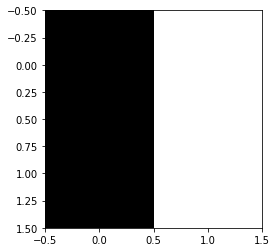

In [0]:
import matplotlib.pyplot as plt

def img_decoder(vec):
  vec = np.array(vec)
  probs = [abs(num)*255/0.5 for num in vec[4:8]]
  color_matrix = probs
  color_matrix = np.array(color_matrix).reshape(2,2)
  plt.imshow(color_matrix, cmap='gray')

img_decoder(state.T)

In [0]:
"""
    training_pure_state.py: training process of qwgan for pure state

"""
import time
from datetime import datetime
# from model.model_pure import Generator, Discriminator, compute_fidelity, compute_cost, get_zero_state
# from tools.plot_hub import plt_fidelity_vs_iter
# from tools.qcircuit import *
# import config_pure as cf
# from tools.utils import save_model, train_log,get_zero_state
import matplotlib.pyplot as plt
import itertools

np.random.seed()

def real_state_matrix(size):

  matrix = np.eye(2**size)
  matrix = np.matmul(Hadamard(size,1, np.pi, False), matrix)
  matrix = np.matmul(Hadamard(size,2, np.pi, False), matrix)
  matrix = np.matmul(Hadamard(size,0, np.pi, False), matrix)
  matrix = np.matmul(X(size,1,np.pi,False), matrix)
  matrix = np.matmul(X(size,2,np.pi,False), matrix)
  matrix = np.matmul(Z_Rotation(size,0,np.pi/4,False), matrix)
  matrix = np.matmul(CNOT_Rotation(size,1,0,np.pi,False), matrix)
  matrix = np.matmul(Z_Rotation(size,0,-np.pi/4,False), matrix)
  matrix = np.matmul(CNOT_Rotation(size,2,0,np.pi,False), matrix)
  matrix = np.matmul(Z_Rotation(size,0,np.pi/4,False), matrix)
  matrix = np.matmul(CNOT_Rotation(size,1,0,np.pi,False), matrix)
  matrix = np.matmul(Z_Rotation(size,0,-np.pi/4,False), matrix)
  matrix = np.matmul(Hadamard(size,0, np.pi, False), matrix)
  matrix = np.matmul(X(size,1,np.pi,False), matrix)
  matrix = np.matmul(X(size,2,np.pi,False), matrix)

  matrix = np.matmul(X(size,2,np.pi,False), matrix)
  matrix = np.matmul(Hadamard(size,0, np.pi, False), matrix)
  matrix = np.matmul(Z_Rotation(size,0,np.pi/4,False), matrix)
  matrix = np.matmul(CNOT_Rotation(size,1,0,np.pi,False), matrix)
  matrix = np.matmul(Z_Rotation(size,0,-np.pi/4,False), matrix)
  matrix = np.matmul(CNOT_Rotation(size,2,0,np.pi,False), matrix)
  matrix = np.matmul(Z_Rotation(size,0,np.pi/4,False), matrix)
  matrix = np.matmul(CNOT_Rotation(size,1,0,np.pi,False), matrix)
  matrix = np.matmul(X(size,2,np.pi,False), matrix)
  matrix = np.matmul(CNOT_Rotation(size,1,0,np.pi,False), matrix)
  matrix = np.matmul(Z_Rotation(size,0,-np.pi/4,False), matrix)
  matrix = np.matmul(Hadamard(size,0, np.pi, False), matrix)
  matrix = np.matmul(X(size,2,np.pi,False), matrix)
  return matrix


def construct_qcircuit(qc,size,layer):
    '''
        the function to construct quantum circuit of generator
    :param qc:
    :param size:
    :return:
    '''

    qc.add_gate(Quantum_Gate("Y", 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Y", 1, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Y", 2, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Z", 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("X", 1, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("CNOT", 1, 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Z", 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("CNOT", 2, 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Z", 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("CNOT", 1, 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Z", 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("X", 1, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Y", 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Y", 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Z", 0, angle=0.2500 * np.pi))
    qc.add_gate(Quantum_Gate("CNOT", 1, 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Z", 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("CNOT", 2, 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Z", 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("CNOT", 1, 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Z", 0, angle=0.5000 * np.pi))
    qc.add_gate(Quantum_Gate("Y", 0, angle=0.5000 * np.pi))

    theta = np.random.random(len(qc.gates))
    for i in range(len(qc.gates)):
      qc.gates[i].angle = theta[i]

    return qc

zero_state = get_zero_state(system_size)
img = [[255,0], [255,0]]
matrix = real_state_matrix(system_size)
real_state = np.matmul(matrix, zero_state)
# real_state = np.matrix([[0.0], [0.5], [0.0], [0.5], \
#                         [0.5], [0.0], [0.5],  [0.0]])
    
# #define generator
# gen = Generator(system_size)
# gen.set_qcircuit(construct_qcircuit(gen.qc,system_size, 1))

# #define discriminator
# herm = [I, X, Y, Z]

# dis = Discriminator(herm, system_size)

# f = compute_fidelity(gen,zero_state,real_state)

# optional term, this is for controlling the initial fidelity is small.
# while(compute_fidelity(gen,zero_state,real_state)>0.5):
#     gen.reset_angles()
# while(compute_fidelity(gen,zero_state,real_state)<0.001):
#   gen.reset_angles()

# losses = []
# fidelities = []


# while(f < 0.9999):

#   starttime = datetime.now()
#   for iter in range(steps):
#     print("==================================================")
#     print("Epoch {}, Step_size {}".format(iter + 1, eta))

#     if iter % step_size == 0:
#       #Generator gradient descent
#       gen.update_gen(dis,real_state)
#       print("Loss after generator step: {}".format(compute_cost(gen, dis,real_state)))

#     #Discriminator gradient ascent
#     dis.update_dis(gen,real_state)
#     print("Loss after discriminator step: {}".format(compute_cost(gen, dis,real_state)))

#     cost = compute_cost(gen, dis, real_state)
#     fidelity = compute_fidelity(gen, zero_state, real_state)

#     losses.append(cost)
#     fidelities.append(fidelity)

#     print("Fidelity between real and fake state: {}".format(fidelity))
#     print("==================================================")

#     if iter % 10 == 0:
#         endtime = datetime.now()
#         training_duration = (endtime - starttime).seconds / np.float(3600)
#         param = 'epoches:{:4d} | fidelity:{:8f} | time:{:10s} | duration:{:8f}\n'.format(iter,round(fidelity,6),time.strftime("%Y-%m-%d %H:%M:%S",time.localtime()),round(training_duration,2))
#         train_log(param, './{}qubit_log_pure.txt'.format(system_size))

#     if (decay):
#         eta = (initial_eta * (epochs - iter - 1) +
#                 (initial_eta) * iter) / epochs

#     f = compute_fidelity(gen,zero_state,real_state)

#   epochs = [epoch for epoch in range(len(losses))]
#   fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
#   axL.plot(epochs, fidelities, linewidth=2)
#   axL.set_title('Fidelities')
#   axL.set_xlabel('steps')
#   axL.set_ylabel('Fidelity between the real state and fake state')
#   axL.grid(True)
#   axR.plot(epochs, losses, linewidth=2)
#   axR.set_title('Cost Function')
#   axR.set_xlabel('steps')
#   axR.set_ylabel('Value of the Cost Function')
#   axR.grid(True)